In [1]:
import os
import struct
import numpy as np
import intvalpy as ip
import matplotlib.pyplot as plt
from functools import cmp_to_key
from pathlib import Path
from tqdm import tqdm

In [2]:
def read_bin_file_with_numpy(file_path):
  with open(file_path, 'rb') as f:
    header_data = f.read(256)
    side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

    frames = []
    point_dtype = np.dtype('<8H')

    for _ in range(frame_count):
      frame_header_data = f.read(16)
      stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
      frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
      frames.append(frame_data)

    return np.array(frames)

In [3]:
def convert_to_voltage(data):
  return data / 16384.0 - 0.5

In [4]:
def scalar_to_interval(x, rad):
  return ip.Interval(x - rad, x + rad)
scalar_to_interval_vec = np.vectorize(scalar_to_interval)

In [5]:
def get_iqr(x):
  q1 = np.percentile(x, 25, axis=0)
  q3 = np.percentile(x, 75, axis=0)
  return q1, q3

In [6]:
def get_box_plot(x):
  q1 = np.percentile(x, 25, axis=0)
  q3 = np.percentile(x, 75, axis=0)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return lower_bound, upper_bound

In [7]:
def intersect_intervals(intervals):
  if len(intervals) == 0:
    return ip.Interval(np.nan, np.nan)

  result = intervals[0]

  if len(intervals) == 1:
    return result

  for interval in intervals:
    result = ip.intersection(result, interval)

  return result

In [8]:
def are_intersected(x, y):
  sup = y.a if x.a < y.a else x.a
  inf = x.b if x.b < y.b else y.b
  return sup - inf <= 1e-15

In [9]:
def are_adjusted_to_each_other(x, y):
  return x.b == y.a or y.b == x.a

In [10]:
def merge_intervals(x, y):
  return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [11]:
def mode(x):
  if len(x) == 0:
    return []

  edges = sorted({x_i.a for x_i in x}.union({x_i.b for x_i in x}))
  z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
  mu = [sum(1 for x_i in x if z_i in x_i) for z_i in z]

  max_mu = max(mu)
  K = [index for index, element in enumerate(mu) if element == max_mu]

  m = [z[k] for k in K]
  merged_m = []

  current_interval = m[0]

  for next_interval in m[1:]:
    if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval, next_interval):
      current_interval = merge_intervals(current_interval, next_interval)
    else:
      merged_m.append(current_interval)
      current_interval = next_interval

  merged_m.append(current_interval)

  return merged_m

In [12]:
def med_k(x):
  starts = [float(interval.a) for interval in x]
  ends = [float(interval.b) for interval in x]
  return ip.Interval(np.median(starts), np.median(ends))

In [13]:
def med_p(x):
    x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))
    mid = len(x) // 2

    if len(x) % 2 == 0:
        return (x[mid - 1] + x[mid]) / 2

    return x[mid]

In [15]:
data_folder = Path('data')
files = sorted([data_folder / f for f in os.listdir(data_folder) if f.endswith('.bin')])
files

[WindowsPath('data/-0.027_lvl_side_a_fast_data.bin'),
 WindowsPath('data/-0.205_lvl_side_a_fast_data.bin'),
 WindowsPath('data/-0.471_lvl_side_a_fast_data.bin'),
 WindowsPath('data/-0.492_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0.061_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0.225_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0.43_lvl_side_a_fast_data.bin'),
 WindowsPath('data/0_lvl_side_a_fast_data_last.bin')]

In [16]:
estimation_functions = [
  ('IQR', get_iqr),
  ('Box plot', get_box_plot),
]

In [18]:
rad = 2 ** -14

for estimation_name, estimation_f in estimation_functions:
  beta_0s = []
  beta_1s = []

  px_num = 1024 * 8

  for px_index in tqdm(range(px_num), desc=estimation_name):
    A = []
    b = []

    for file_path in files:
      x = float(file_path.name.split('_')[0])
      frames = read_bin_file_with_numpy(file_path)
      ys = []

      for frame in frames:
        px = frame.flatten()[px_index]
        ys.append(px)

      y = estimation_f(ys)

      A.append([[x , x ], [1 , 1]])
      b.append(y)

    A = ip.Interval(A)
    b = ip.Interval(b)

    x = ip.linear.Rohn(A, b)
    beta_0s.append(x[1])
    beta_1s.append(x[0])

  beta_0_intersected = intersect_intervals(beta_0s)
  beta_1_intersected = intersect_intervals(beta_1s)
  print('Intersection: ', beta_0_intersected, beta_1_intersected)

  beta_0_med_k = med_k(beta_0s)
  beta_1_med_k = med_k(beta_1s)
  print('Med_k: ', beta_0_med_k, beta_1_med_k)

  beta_0_med_p = med_p(beta_0s)
  beta_1_med_p = med_p(beta_1s)
  print('Med_p: ', beta_0_med_p, beta_1_med_p)

  beta_0_mode = mode(beta_0s)
  beta_1_mode = mode(beta_1s)
  print('Mode: ', beta_0_mode, beta_1_mode)

IQR: 100%|██████████| 8192/8192 [02:44<00:00, 49.79it/s]


Intersection:  '[nan, nan]' '[nan, nan]'
Med_k:  '[8029.18, 8190.85]' '[12857, 13289.5]'
Med_p:  '[8023.65, 8195.88]' '[12879.9, 13280.5]'
Mode:  ['[8083.32, 8083.33]', '[8086.78, 8086.8]'] ['[13074.2, 13074.5]']


Box plot: 100%|██████████| 8192/8192 [02:42<00:00, 50.36it/s]


Intersection:  '[7928.86, 8223.23]' '[13101.8, 13570.1]'
Med_k:  '[7780.52, 8430.21]' '[12193, 13950.3]'
Med_p:  '[7765.31, 8454.22]' '[12279.1, 13881.3]'
Mode:  ['[7928.86, 8223.23]'] ['[13101.8, 13570.1]']


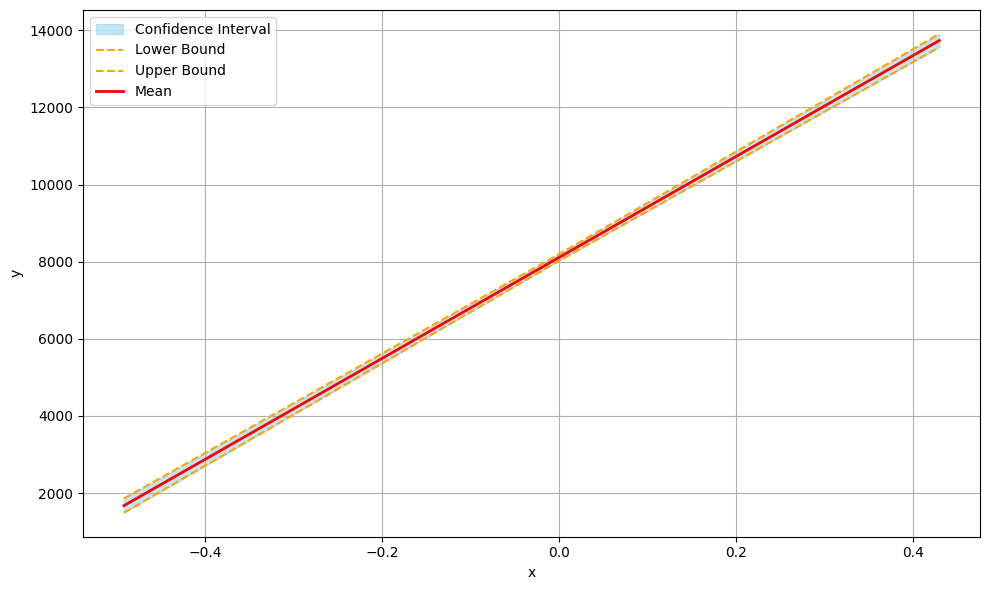

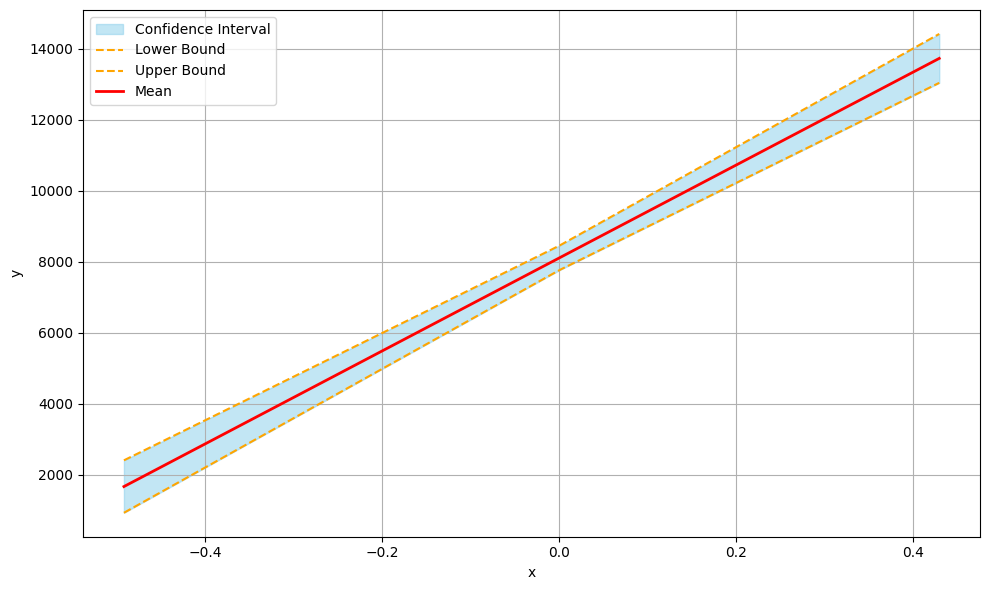

In [19]:
beta_0_int = ip.Interval(8023.65, 8195.88)
beta_1_int = ip.Interval(12879.9, 13280.5)

beta_0_ext = ip.Interval(7765.31, 8454.22)
beta_1_ext = ip.Interval(12279.1, 13881.3)

xs = np.array([float(file_path.name.split('_')[0]) for file_path in files])
xs_continuous = np.linspace(xs.min(), xs.max(), 100)

for (beta_0, beta_1) in ((beta_0_int, beta_1_int), (beta_0_ext, beta_1_ext)):
  ys = beta_0 + beta_1 * xs_continuous
  ys_a = np.array([float(interval.a) for interval in ys])
  ys_b = np.array([float(interval.b) for interval in ys])

  plt.figure(figsize=(10, 6))
  plt.fill_between(xs_continuous, ys_a, ys_b, color='skyblue', alpha=0.5, label='Confidence Interval')
  plt.plot(xs_continuous, ys_a, color='orange', linewidth=1.5, linestyle='--', label='Lower Bound')
  plt.plot(xs_continuous, ys_b, color='orange', linewidth=1.5, linestyle='--', label='Upper Bound')
  plt.plot(xs_continuous, (ys_a + ys_b) / 2, color='red', linewidth=2, label='Mean')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()